# Task 1

Result of Task 1 can be found by running `main.py` and accessing the API through http://127.0.0.1:8000/api/v1/rec/user/{user_id}.

# Task 2

###### Hide

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()

from _load_data import *
from _engineer_features import *

In [2]:
df_user, df_menu, df_sales, df_bridge = load_data()
df_user, df_menu, df_sales, df_bridge, df_rating = engineer_features(
    df_user, df_menu, df_sales, df_bridge
    )

In [26]:
df_menu

,menu_id,concept,brand,menu_category,menu_category_detail,menu_name,last_sold,avg_sales_interval
0,5204e17e-aefb-4235-8eb8-7177a5679352,Lifestyle,A/A,FOOD,APPETIZER,french fries,14 days 04:41:53,71 days 22:51:21
1,f026874c-5a66-4184-8ce0-9aeb9e37b5ac,Lifestyle,A/A,LIQUEUR,WHISK(E)Y,monkey shoulder_double,86 days 03:33:14,16 days 18:16:30.028860028
2,cfa23fc2-c4ab-4377-b0fe-489493016af1,Lifestyle,A/A,LIQUEUR,WHISK(E)Y,lagavulin 16 yo (glass),86 days 03:33:14,16 days 18:16:30.028860028
3,9708a976-0852-4705-a619-359447db7b09,Lifestyle,A/A,LIQUEUR,COCKTAIL,lemon drop,86 days 03:33:14,16 days 18:16:30.028860028
4,5aca9660-a702-4590-82dd-4c3666204fb8,Lifestyle,A/A,LIQUEUR,COCKTAIL,ginger,55 days 03:02:34,5 days 04:05:06.666666666
...,...,...,...,...,...,...,...,...
2010,85d91c3d-f2bb-4a1f-8cc4-b84352fc153a,Resto,Djournal House,FOOD,SOUP & SALAD,chicken sesame salad,54 days 06:26:21,6 days 23:26:18.800000
2011,d514f3e5-f9b1-46ff-9b47-fce239798e9a,Resto,Djournal House,BEVERAGE,WATER & SOFT DRINKS,aqua sparkling,89 days 03:37:55,16 days 07:02:24.376666666
2012,b49d2d3c-5182-4e7d-a54b-381a79e49eb6,Resto,Djournal House,BEVERAGE,TEA & COFFEE,earl grey,45 days 14:44:49,16 days 07:02:24.376666666
2013,78c8bb3b-d54c-474b-b04b-d66f42b9036e,Resto,Djournal House,BEVERAGE,TEA & COFFEE,hot premium tea,45 days 14:44:49,16 days 07:02:24.376666666


In [145]:
concept_aggregator = {
    f"count_concept_{concept}": ('concept', lambda x,concept=concept: np.sum(x == concept))
    for concept in df_menu['concept'].unique()
    }

menu_category_aggregator = {
    f"count_menu_category_{menu_category}": ('menu_category', lambda x,menu_category=menu_category: np.sum(x == menu_category))
    for menu_category in df_menu['menu_category'].unique()
    }

brand_aggregator = {
    f"count_brand_{brand}": ('brand', lambda x,brand=brand: np.sum(x == brand))
    for brand in df_menu['brand'].unique()
    }

TIME_INTERVAL = pd.to_timedelta('1W')

df = (df_user
 .merge(
     df_bridge
    .merge(df_sales, on='sales_id')
    .merge(df_menu, on='menu_id')
    .groupby('user_id')
    .agg(**{**concept_aggregator,
            **menu_category_aggregator,
            **brand_aggregator})
    .reset_index()
    )
 .assign(
     time_since_created=lambda x: x['time_since_created'] / TIME_INTERVAL,
     avg_trx_interval=lambda x: x['avg_trx_interval'] / TIME_INTERVAL,
     freq_concept_Lifestyle=lambda x: x['count_concept_Lifestyle'] / x['time_since_created'],
     freq_concept_Resto=lambda x: x['count_concept_Resto'] / x['time_since_created'],
     freq_menu_category_FOOD=lambda x: x['count_menu_category_FOOD'] / x['time_since_created'],
     freq_menu_category_LIQUEUR=lambda x: x['count_menu_category_LIQUEUR'] / x['time_since_created'],
     freq_menu_category_BEVERAGE=lambda x: x['count_menu_category_BEVERAGE'] / x['time_since_created'],
     freq_menu_category_CIGARETTE=lambda x: x['count_menu_category_CIGARETTE'] / x['time_since_created'],
     freq_menu_category_BEER=lambda x: x['count_menu_category_BEER'] / x['time_since_created'],
     freq_menu_category_WINE=lambda x: x['count_menu_category_WINE'] / x['time_since_created'],
 )
 .drop([
     'count_concept_Lifestyle', 'count_concept_Resto',
    'count_menu_category_FOOD', 'count_menu_category_LIQUEUR',
    'count_menu_category_BEVERAGE', 'count_menu_category_CIGARETTE',
    'count_menu_category_BEER', 'count_menu_category_WINE'], axis=1)
#   .groupby(['user_gender', 'user_tier_level'])
#  .agg({
#      'user_id': 'count',
#      'time_since_created': 'mean',
#      'avg_trx_interval': 'mean',
#      'freq_concept_Lifestyle': 'mean',
#      'freq_concept_Resto': 'mean',
#     'freq_menu_category_FOOD': 'mean',
#     'freq_menu_category_LIQUEUR': 'mean',
#     'freq_menu_category_BEVERAGE': 'mean',
#     'freq_menu_category_CIGARETTE': 'mean',
#     'freq_menu_category_BEER': 'mean',
#     'freq_menu_category_WINE': 'mean',
#      })
 )

# df = pd.wide_to_long(df, stubnames=['freq_concept'], i=['user_id'], j='concept', sep='_', suffix='.*').reset_index()
# df = pd.wide_to_long(df, stubnames=['freq_menu_category'], i=['user_id', 'concept'], j='menu_category', sep='_', suffix='.*').reset_index()

df

,user_id,user_created_at,user_tier_level,user_gender,time_since_created,avg_trx_interval,count_brand_A/A,count_brand_Djournal,count_brand_Osteria GIA,count_brand_Publik Markette,...,count_brand_Manarai,count_brand_Djournal House,freq_concept_Lifestyle,freq_concept_Resto,freq_menu_category_FOOD,freq_menu_category_LIQUEUR,freq_menu_category_BEVERAGE,freq_menu_category_CIGARETTE,freq_menu_category_BEER,freq_menu_category_WINE
0,db0df3a5-2d00-4fed-93b1-99ea1eedccd8,2021-05-13 07:41:27,Gold,F,98.239936,1.109969,16,2,27,3,...,0,0,0.437704,0.050896,0.081433,0.356271,0.030537,0.000000,0.020358,0.000000
1,03fb92e2-5a88-4461-82d6-b457b61fea64,2021-04-28 07:21:38,Gold,F,100.384759,3.338921,0,4,5,0,...,0,0,0.189272,0.039847,0.089655,0.000000,0.139463,0.000000,0.000000,0.000000
2,a0e1b99e-a65a-429d-981d-0c507fc49eee,2021-04-07 08:32:46,Gold,F,103.377702,0.828638,0,25,0,0,...,0,0,0.222485,0.280525,0.135426,0.067713,0.280525,0.009673,0.009673,0.000000
3,d390573f-f3e1-40f7-b6bb-f04405fa0e72,2022-02-20 04:58:38,Gold,F,57.827517,0.419534,0,87,0,0,...,0,0,0.000000,1.556353,0.155635,0.000000,1.400717,0.000000,0.000000,0.000000
4,2ffd0dbf-cbdf-4b8a-9ab0-4c8414a73ebd,2022-07-16 02:56:11,Gold,F,36.982521,0.707948,0,17,0,53,...,0,0,0.000000,1.946866,0.594876,0.000000,1.351990,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,a608ec05-2770-479e-830c-00c1b66d2361,2021-10-06 09:26:37,Basic,M,77.372359,3.775871,0,4,0,0,...,0,0,0.000000,0.077547,0.025849,0.000000,0.051698,0.000000,0.000000,0.000000
996,e9dbac1a-68bc-413c-8130-852fba855d92,2021-10-24 05:36:36,Basic,M,74.823750,3.775871,0,1,0,0,...,0,0,0.000000,0.080188,0.066824,0.000000,0.013365,0.000000,0.000000,0.000000
997,fa2b2ff7-f9f3-4705-9e02-a8e0760a74f5,2021-03-29 02:55:11,Black,M,104.696906,0.165883,0,101,20,0,...,0,1,0.324747,1.279885,0.324747,0.133719,1.146166,0.000000,0.000000,0.000000
998,1b8b50e6-ff58-4e49-a1df-9dda976a0c18,2021-03-29 03:36:37,Black,M,104.692796,0.398061,0,0,7,5,...,0,15,0.238794,0.372518,0.324760,0.028655,0.200587,0.000000,0.019104,0.038207


## Result

Frequency is in per week. Other than that it's in week. We can utilize tier and gender to segment customers.

Female with high tier may be given vouchers to lifestyle brand while male with high tier may be given vouchers to resto brand.

For lower tier, we can give vouchers to gather more data and learn their preference. We then can use the recommendation system to recommend them their preferred menus.

* The higher the tier, the longer they have been member

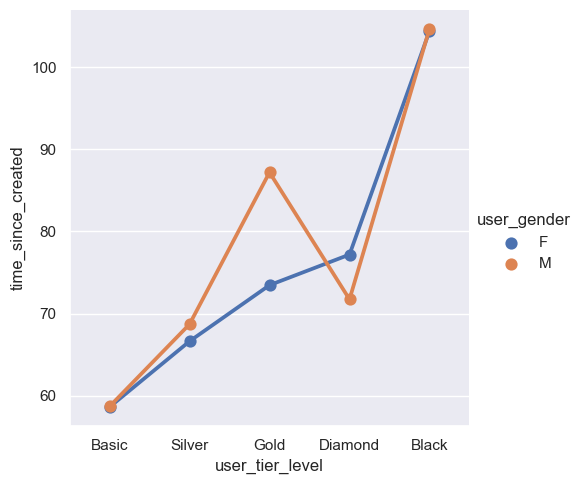

In [129]:
sns.catplot(x='user_tier_level', y='time_since_created', hue='user_gender', kind='point', errorbar=None, data=df)

* The higher the tier, the shorter their transaction interval

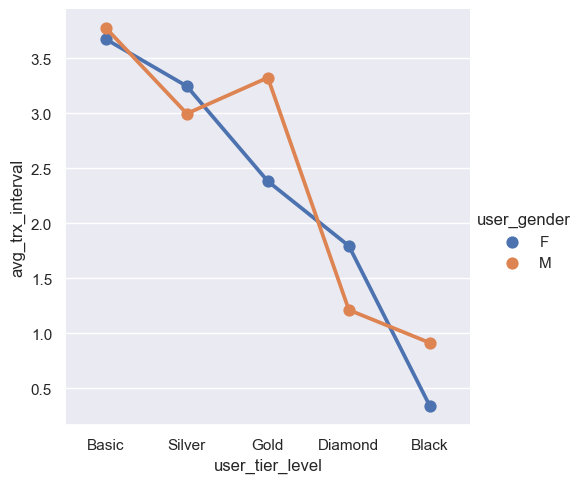

In [133]:
sns.catplot(x='user_tier_level', y='avg_trx_interval', hue='user_gender', kind='point', errorbar=None, data=df)

* The higher the tier, female tend to choose lifestyle over resto.

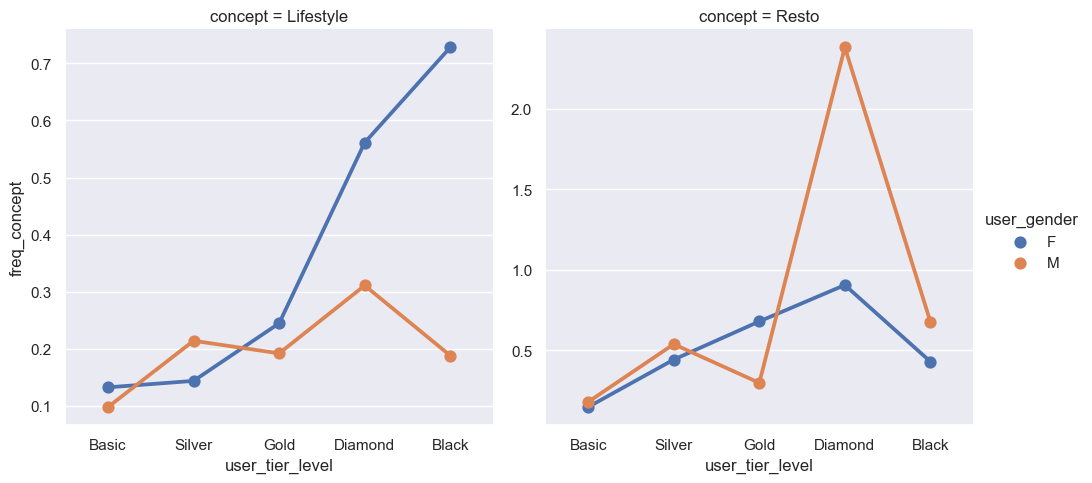

In [148]:
df_temp = pd.wide_to_long(df, stubnames=['freq_concept'], i=['user_id'], j='concept', sep='_', suffix='.*').reset_index()

sns.catplot(x='user_tier_level', y='freq_concept', col='concept', hue='user_gender', sharey=False, kind='point', errorbar=None, data=df_temp)

* The previous trend can also be seen here, where LIQUEUR, CIGARETTE, and WINE are higher on females with higher tier.

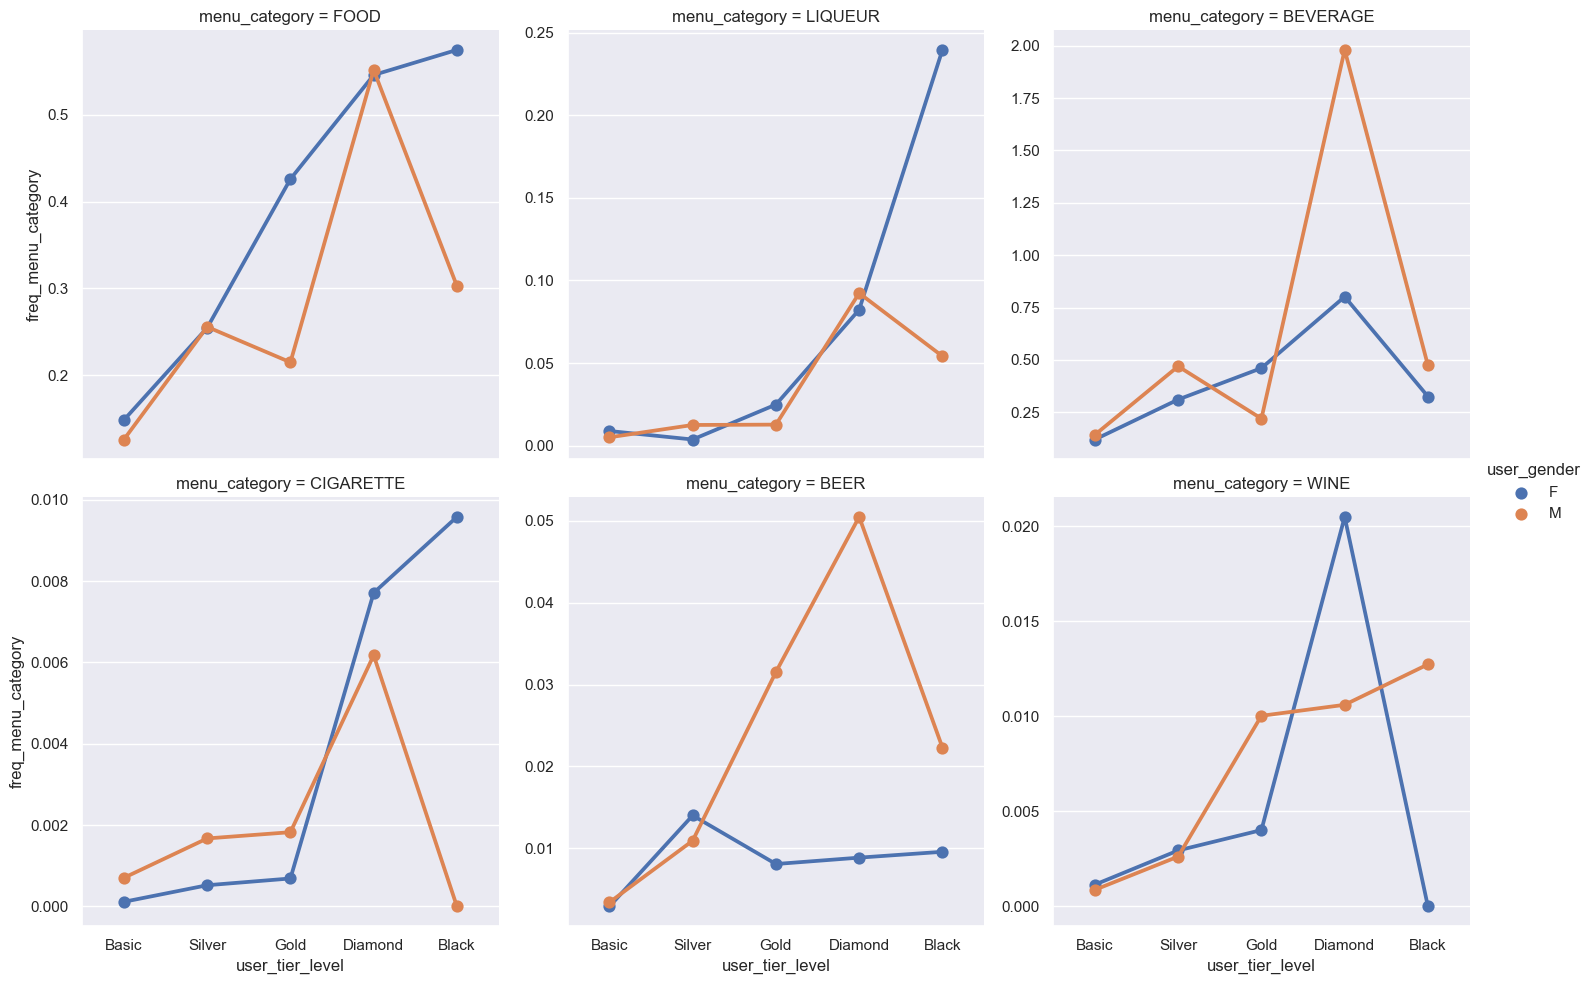

In [144]:
df_temp = pd.wide_to_long(df, stubnames=['freq_menu_category'], i=['user_id'], j='menu_category', sep='_', suffix='.*').reset_index()

sns.catplot(x='user_tier_level', y='freq_menu_category', col='menu_category', hue='user_gender', kind='point', col_wrap=3, sharey=False, errorbar=None, data=df_temp)